In [1]:
import numpy as np
import cvxpy
import matplotlib.pyplot as plt
#from DrawingUtils import plot_extreme_points,graph_plane,PlotPolytope
import random as rnd
import time
from IPython.display import clear_output

%matplotlib notebook
%matplotlib inline
%config InlineBackend.close_figures=True

# Partial McCormick Inequalities

We consider some subset of the inequalities so that there are only 2 at a time. We test this with the Lotka-Volterra implementation.

# Core functions

## Constructing linear constraints using McCormick envelopes

In [2]:
def McCormick(w,x,y,x_bounds,y_bounds,whichBounds=[True,True,True,True]):
    xL,xU = x_bounds
    yL,yU = y_bounds

    c = []
    if whichBounds[0]: c.append(w >= xL*y + x*yL - xL*yL)
    if whichBounds[1]: c.append(w >= xU*y + x*yU - xU*yU)
    if whichBounds[2]: c.append(w <= xU*y + x*yL - xU*yL)
    if whichBounds[3]: c.append(w <= x*yU + xL*y - xL*yU)
    
    return c

## Solving linear program

In [3]:
def bounds(x,constraints,Npast=0):

    objective_max = cvxpy.Maximize(x)
    problem_maximum = cvxpy.Problem(objective_max,constraints[-Npast:])
    value_max = problem_maximum.solve(solver=cvxpy.GUROBI)

    objective_min = cvxpy.Minimize(x)
    problem_minimum = cvxpy.Problem(objective_min,constraints[-Npast:])
    value_min = problem_minimum.solve(solver=cvxpy.GUROBI)

    return (value_min,value_max)

In [6]:
def vanDerPolConstraints(T=1,variables=[],constants={},constraints=[],control_bounds=[],Npast=0,whichBounds=[True,True,True,True],plot=True):
    times = []
    ss = []
    for t in range(T):
        tt = time.time()
        
        x = variables[t]["x"]
        x_bounds = bounds(x,constraints,Npast=Npast)
        y = variables[t]["y"]
        y_bounds = bounds(y,constraints,Npast=Npast)

        ######### lil plot
        xL,xU = x_bounds
        yL,yU = y_bounds
#         clear_output(wait=True)
        if plot:
            fig = plt.figure(1)
            if t>0: 
                #plt.clf()
                plt.plot([x_lw_b,x_lw_b,x_up_b,x_up_b,x_lw_b],[y_lw_b,y_up_b,y_up_b,y_lw_b,y_lw_b],'b')
                plt.plot([xL,xL,xU,xU,xL],[yL,yU,yU,yL,yL],'k')
                # print("x_b: ",x_bounds)
                # print("y_b: ",y_bounds)
            fig.canvas.draw()   # draw
            plt.pause(1.01)
        box_size = (xU-xL)*(yU-yL)
        ss.append(box_size)
        ########
        
        u = variables[t]["u"]
        u_bounds = control_bounds[t]
        constraints.append(u <= u_bounds[1])
        constraints.append(u >= u_bounds[0])

        n = variables[t]["n"]
        constraints.extend(McCormick(n,x,x,x_bounds,x_bounds,whichBounds=whichBounds))

        v = variables[t]["v"]
        constraints.append(v == 1 - n)
        v_bounds = bounds(v,constraints,Npast=Npast)

        w = variables[t]["w"]
        constraints.extend(McCormick(w,y,v,y_bounds,v_bounds,whichBounds=whichBounds))
        w_bounds = bounds(w,constraints,Npast=Npast)        

        z = variables[t]["z"]
        constraints.extend(McCormick(z,u,w,u_bounds,w_bounds,whichBounds=whichBounds)) 

        y_new = variables[t+1]["y"]
        constraints.append(y_new == z*del_t - x*del_t + y)

        x_new = variables[t+1]["x"]
        constraints.append(x_new == y*del_t + x)

        tt = time.time() - tt
        times.append(tt)
        
        #print("Time for ",t,"-th loop: ",tt)

    # plt.figure(2)
    # plt.plot(times,'r*')
    
    return variables,constraints,ss,times

## Initial Setup

In [7]:
# horizon and forward Euler time step
T = 20
del_t = -0.1

# box constraints for initial state
x0 = 1
y0 = 1
x_dev = 0.01
y_dev = 0.01

x_up_b = x_dev + x0
x_lw_b = -1*x_dev + x0
y_up_b = y_dev + y0
y_lw_b = -1*y_dev + y0

bounds_set = [
    [True,True,True,True],
    [True,False,True,False],
    [True,False,False,True],
    [False,True,True,False],
    [False,True,False,True]
]
bounds_type = {0:"All", 1:"Firsts", 2:"First-Second", 3:"Second-First", 4:"Seconds"}

## Generate plots for different subsets of McCormick inequalities

In [8]:
c = {}
i = 0
sizes = {}
bounds_times = {}

for b in bounds_set:
    variables = [{"u":cvxpy.Variable(),"x":cvxpy.Variable(),"y":cvxpy.Variable(),"z":cvxpy.Variable(),"w":cvxpy.Variable(),"v":cvxpy.Variable(),"n":cvxpy.Variable()} for t in range(T+1)]

    x = variables[0]["x"]
    y = variables[0]["y"]

    constraints = []
    constraints.append(x >= x_lw_b)
    constraints.append(x <= x_up_b)
    constraints.append(y >= y_lw_b)
    constraints.append(y <= y_up_b)

    control_bounds = [(0.2,1.0) for t in range(T)]

    variables,constraints,ss,times = vanDerPolConstraints(T,variables,c,constraints,control_bounds,whichBounds=b,plot=False)
    
    xL,xU = bounds(variables[-1]["x"],constraints)
    yL,yU = bounds(variables[-1]["y"],constraints)
    
    box_size = (xU-xL)*(yU-yL)
    ss.append(box_size)
    
    sizes[i] = ss
    bounds_times[i] = times

    i += 1

Academic license - for non-commercial use only


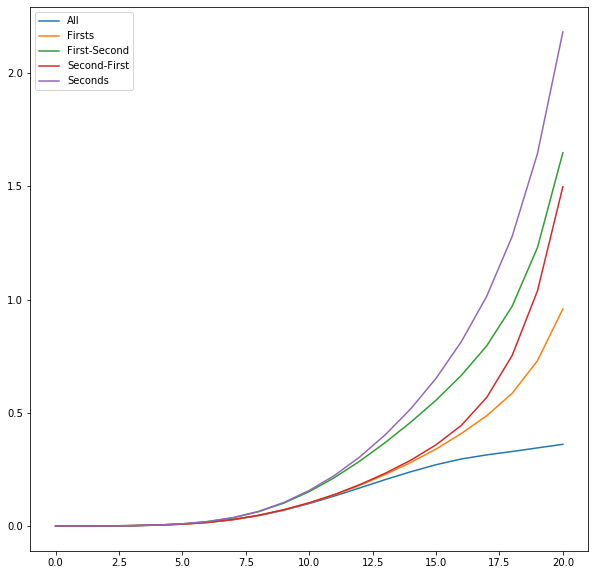

In [11]:
plt.figure(figsize=(10,10))
for i in range(len(bounds_set)):
    plt.plot(list(range(T+1)),sizes[i],label=bounds_type[i])
plt.legend()
plt.show()

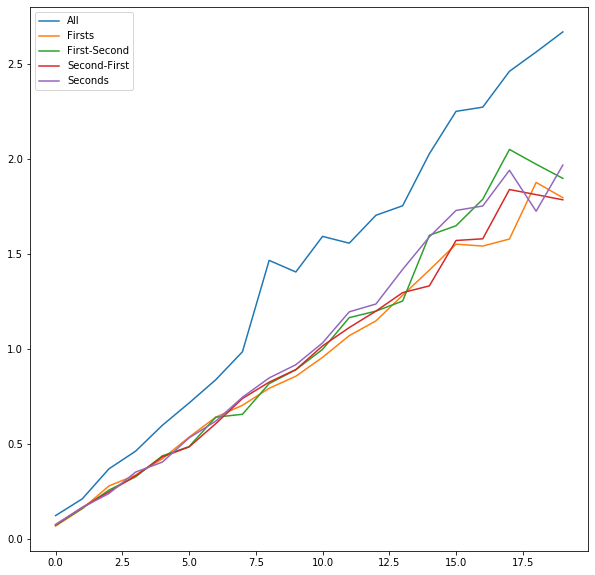

In [12]:
plt.figure(figsize=(10,10))
for i in range(len(bounds_set)):
    plt.plot(list(range(T)),bounds_times[i],label=bounds_type[i])
plt.legend()
plt.show()